# Millstone3
## TASK4
### focus on entertainment category

- compare like-ratio between entertainment category videos and other categories.
- casual analysis for the effect of conspiracy words about like-ratio in one certain channel

### Part1 like-ratio analysis

compare like-ratio betwen entertainment category and other categories.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df_timeseries = pd.read_csv('df_timeseries_en.tsv', sep='\t', parse_dates=['datetime'])
df_videos = pd.read_json('yt_metadata_filtered_"trump ".jsonl', lines=True)

df_trump_entertainment_videos = df_videos[df_videos['categories'] == 'Entertainment']
df_trump_non_entertainment_videos = df_videos[df_videos['categories'] != 'Entertainment']

print(f'the shape of entertainment videos are : {df_trump_entertainment_videos.shape}')
print(f'the shape of non-entertainment videos are : {df_trump_non_entertainment_videos.shape}')

the shape of entertainment videos are : (44392, 13)
the shape of non-entertainment videos are : (403224, 13)


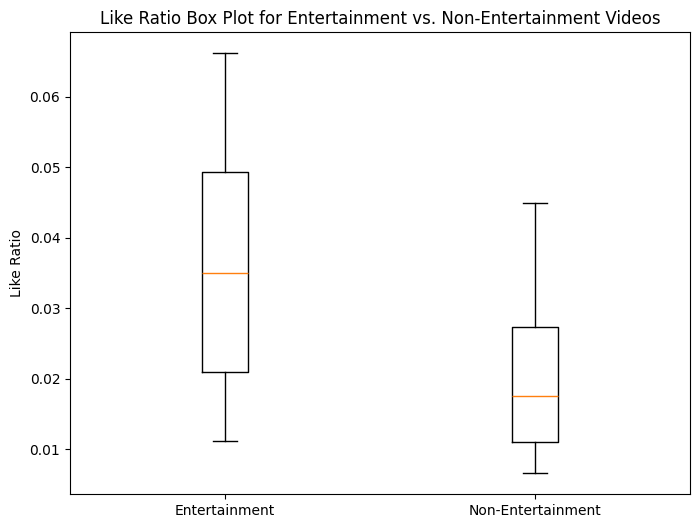

In [2]:
# 比较enterainment和non-enterainment的视频的点赞比例，方法为 (like_count - 0.5*dislike_count)/view_count
# 筛选掉view_count为0的视频
df_trump_entertainment_videos = df_trump_entertainment_videos[df_trump_entertainment_videos['view_count'] > 0]
df_trump_non_entertainment_videos = df_trump_non_entertainment_videos[df_trump_non_entertainment_videos['view_count'] > 0]

pd.options.mode.chained_assignment = None
df_trump_entertainment_videos['like_ratio'] = (df_trump_entertainment_videos['like_count'] - 0.5*df_trump_entertainment_videos['dislike_count']) / df_trump_entertainment_videos['view_count']
df_trump_non_entertainment_videos['like_ratio'] = (df_trump_non_entertainment_videos['like_count'] - 0.5*df_trump_non_entertainment_videos['dislike_count']) / df_trump_non_entertainment_videos['view_count']

# 排序
df_trump_entertainment_videos = df_trump_entertainment_videos.sort_values(by='like_ratio', ascending=False)
df_trump_non_entertainment_videos = df_trump_non_entertainment_videos.sort_values(by='like_ratio', ascending=False)

# 画出boxplox图,为了减少误差，只对25%-75%的数据进行画图

df_trump_entertainment_videos_new = df_trump_entertainment_videos[df_trump_entertainment_videos['like_ratio'] > df_trump_entertainment_videos['like_ratio'].quantile(0.25)]
df_trump_entertainment_videos_new = df_trump_entertainment_videos_new[df_trump_entertainment_videos_new['like_ratio'] < df_trump_entertainment_videos_new['like_ratio'].quantile(0.75)]

df_trump_non_entertainment_videos_new = df_trump_non_entertainment_videos[df_trump_non_entertainment_videos['like_ratio'] > df_trump_non_entertainment_videos['like_ratio'].quantile(0.25)]
df_trump_non_entertainment_videos_new = df_trump_non_entertainment_videos_new[df_trump_non_entertainment_videos_new['like_ratio'] < df_trump_non_entertainment_videos_new['like_ratio'].quantile(0.75)]

plt.figure(figsize=(8, 6))
plt.boxplot([df_trump_entertainment_videos_new['like_ratio'], df_trump_non_entertainment_videos_new['like_ratio']], tick_labels=['Entertainment', 'Non-Entertainment'])
plt.title('Like Ratio Box Plot for Entertainment vs. Non-Entertainment Videos')
plt.ylabel('Like Ratio')
plt.show()

We can find that for entertainment category videos, they have more tendency to have higher like-ratios.

### Part 2 Casual analysis for conspiracy words

analysize for the effect of like-ratio of videos after adding conspiracy words in the video title or descriptions.

In [17]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors


df_timeseries = pd.read_csv('df_timeseries_en.tsv', sep='\t', parse_dates=['datetime'])
df_videos = pd.read_json('yt_metadata_filtered_"trump ".jsonl', lines=True)

conspiracy_keywords = {
    "Deep State": ["deepstate", "deep state", "government faction", "shadow government", "hidden government"],
    "Election Fraud": ["election fraud", "vote fraud", "mail-in ballots", "voter suppression", "rigged election"],
    "QAnon": ["qanon", "cabal", "child trafficking", "satanic rituals", "deep-rooted cabal", "Q movement"],
    "Missing Emails": ["missing emails", "deleted emails", "clinton emails", "email scandal", "email leak"],
    "Biden Family Scandal": ["biden family scandal", "hunter biden", "biden corruption", "biden business dealings", "biden influence"],
    "Climate Change Hoax": ["climate change hoax", "global elites", "climate profit", "false climate", "climate deception"]
}


# 数据准备
target_channel = 'UCLoNQH9RCndfUGOb2f7E1Ew'
df_videos_channel = df_videos[df_videos['channel_id'] == target_channel].copy()
df_timeseries_channel = df_timeseries[df_timeseries['channel'] == target_channel].copy()

print(df_videos_channel.shape)

# 检测阴谋论关键词
detected_columns = {theory: [] for theory in conspiracy_keywords.keys()}

# for _, row in df_videos_channel.iterrows():
#     text = ' '.join([str(row.get('title', '')), 
#                      str(row.get('tags', '')), 
#                      str(row.get('description', ''))]).lower()


for _, row in df_videos_channel.iterrows():
    text = str(row.get('title', '')).lower()
    
    for theory, keywords in conspiracy_keywords.items():
        pattern = re.compile('|'.join([re.escape(word.lower()) for word in keywords]), re.IGNORECASE)
        detected_columns[theory].append(1 if pattern.search(text) else 0)

for theory, values in detected_columns.items():
    df_videos_channel.loc[:, theory] = values

# 添加总体阴谋标志
df_videos_channel['is_conspiracy'] = df_videos_channel[
    list(conspiracy_keywords.keys())
].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# 基础统计
total_videos = len(df_videos_channel)
conspiracy_videos = df_videos_channel[df_videos_channel['is_conspiracy'] == 1]
non_conspiracy_videos = df_videos_channel[df_videos_channel['is_conspiracy'] == 0]

print(f"Total videos: {total_videos}")
print(f"Conspiracy keyword videos: {len(conspiracy_videos)} ({len(conspiracy_videos)/total_videos*100:.2f}%)")

(15181, 13)
Total videos: 15181
Conspiracy keyword videos: 137 (0.90%)


In [18]:
import pandas as pd
from datetime import datetime
import numpy as np

def merge_channel_data(df_videos_channel, df_timeseries_channel):
    df_videos_channel['upload_date'] = pd.to_datetime(df_videos_channel['upload_date'])
    df_timeseries_channel['datetime'] = pd.to_datetime(df_timeseries_channel['datetime'])
    
    df_timeseries_channel = df_timeseries_channel.sort_values('datetime')
    df_result = df_videos_channel.copy()
    
    def binary_search_timeseries(upload_time):
        left, right = 0, len(df_timeseries_channel) - 1
        
        while left <= right:
            mid = (left + right) // 2
            current_datetime = df_timeseries_channel.iloc[mid]['datetime']
            
            if mid == len(df_timeseries_channel) - 1:
                return None
            
            next_datetime = df_timeseries_channel.iloc[mid + 1]['datetime']
            
            if current_datetime <= upload_time < next_datetime:
                return {
                    'subs': df_timeseries_channel.iloc[mid]['subs'],
                    'activity': df_timeseries_channel.iloc[mid]['activity'],
                    'delta_videos': df_timeseries_channel.iloc[mid]['delta_videos'],
                }
            
            if upload_time < current_datetime:
                right = mid - 1
            else:
                left = mid + 1
        
        return None
    
    for index, row in df_result.iterrows():
        result = binary_search_timeseries(row['upload_date'])
        
        if result is not None:
            df_result.at[index, 'subs'] = result['subs']
            df_result.at[index, 'activity'] = result['activity']
            df_result.at[index, 'delta_videos'] = result['delta_videos']
    
    
    return df_result

# 使用示例
df_videos_channel = merge_channel_data(df_videos_channel, df_timeseries_channel)

# 把subs为NAN的数据删除
df_videos_channel = df_videos_channel.dropna(subset=['subs'])



In [19]:
# 计算点赞率
df_videos_channel['engagement_rate'] = (
    df_videos_channel['like_count'] - (df_videos_channel['dislike_count'] * 0.5)
) / df_videos_channel['view_count']

# 倾向得分计算
X = df_videos_channel[['duration','subs','activity','delta_videos']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ps_model = LogisticRegression()
ps_model.fit(X_scaled, df_videos_channel['is_conspiracy'])
df_videos_channel['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]


# Step 4: 最近邻匹配
from sklearn.neighbors import NearestNeighbors

# 阴谋论视频和非阴谋论视频分类
treated = df_videos_channel[df_videos_channel['is_conspiracy'] == 1]
control = df_videos_channel[df_videos_channel['is_conspiracy'] == 0]

# 最近邻匹配
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# 获取匹配对
matched_control = control.iloc[indices.flatten()].copy()
matched_control['treated_index'] = treated.index

# 合并匹配样本
matched = pd.concat([treated, matched_control], axis=0)

# Step 5: 分析点赞率差异
# 描述性统计
comparison = matched.groupby('is_conspiracy')['engagement_rate'].mean()
print("\nEngagement Rate Comparison:")
print(comparison)

from scipy.stats import shapiro, mannwhitneyu, ttest_ind

# 检查正态性
stat, p_value = shapiro(matched['view_count'])
print(f"Shapiro-Wilk Test: statistic={stat}, p-value={p_value}")

if p_value > 0.05:
    # 使用 t 检验
    t_stat, t_p = ttest_ind(
        matched[matched['is_conspiracy'] == 1]['engagement_rate'],
        matched[matched['is_conspiracy'] == 0]['engagement_rate']
    )
    print(f"\nT-Test: t-statistic={t_stat}, p-value={t_p}")
else:
    # 使用 Mann-Whitney U 检验
    u_stat, u_p = mannwhitneyu(
        matched[matched['is_conspiracy'] == 1]['engagement_rate'],
        matched[matched['is_conspiracy'] == 0]['engagement_rate']
    )
    print(f"\nMann-Whitney U Test: statistic={u_stat}, p-value={u_p}")


Engagement Rate Comparison:
is_conspiracy
0    0.057420
1    0.063972
Name: engagement_rate, dtype: float64
Shapiro-Wilk Test: statistic=0.6091054958188235, p-value=2.2153800443910235e-23

Mann-Whitney U Test: statistic=9195.0, p-value=0.007651016017211883


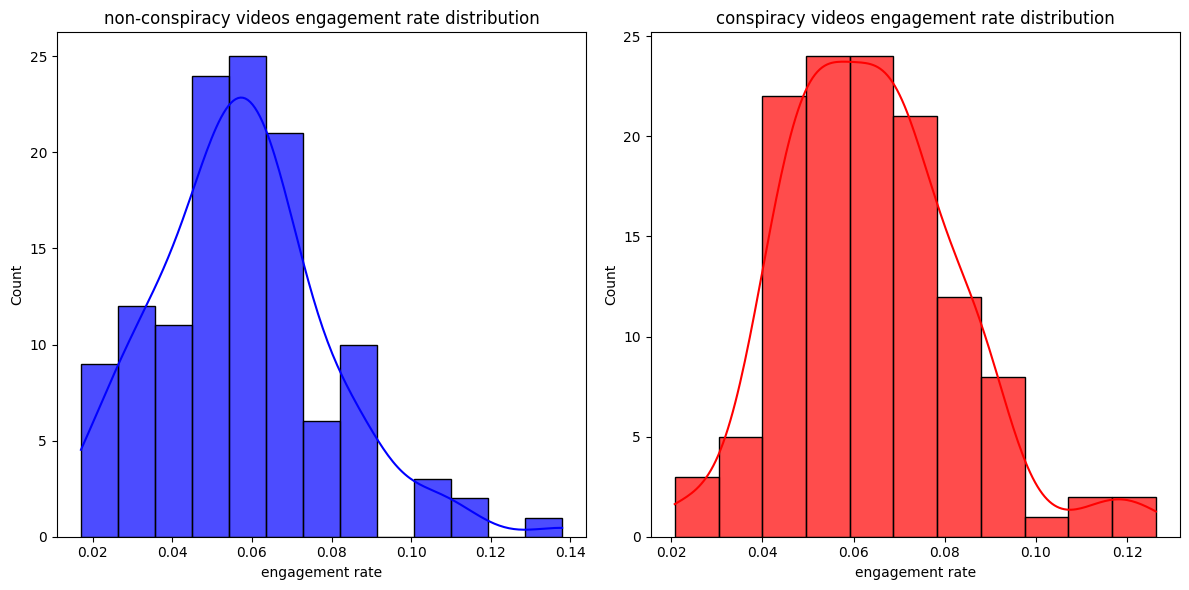

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=matched[matched['is_conspiracy'] == 0], 
             x='engagement_rate', kde=True, color='blue', alpha=0.7)
plt.title('non-conspiracy videos engagement rate distribution', fontsize=12)
plt.xlabel('engagement rate', fontsize=10)

plt.subplot(1, 2, 2)
sns.histplot(data=matched[matched['is_conspiracy'] == 1], 
             x='engagement_rate', kde=True, color='red', alpha=0.7)
plt.title('conspiracy videos engagement rate distribution', fontsize=12)
plt.xlabel('engagement rate', fontsize=10)

plt.tight_layout()
plt.show()

We can find that there is strong difference between conspiracy videos and non-conspiracy videos on engagement rate.